**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 26 de setiembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido). En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569


# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569 - Parte 1

#### Considerations: 

#### • This notebook loads the whole dataset and only resizes the images in a 50% so in the basic version of Google Colab will not work, it is needed at least 20 MB RAM.

#### • If you run this in Anaconda or Jupyter Notebook yo need to 'pip install' all the required imports

## 0. Import required libraries (Used by part 1 and part 2 of this project)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
import wandb

from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization


## 1 - Load Data

### • We load initially the data from the CSV file

In [2]:
#Load data from CSV path
csv_path = './ham10000_metadata.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB


### • Now we build a dataset composed by the images and the corresponding label values (melanocytic = True/False)

### We also apply a resize of 50% on the images dimensions in order to reduce the memory consumption that we will have to do while building, splitting and handling the data

In [3]:
#Build dataset with images + corresponding label
def load_data(data_path, resize_dimensions = [0.5, 0.5]):
    images = []
    labels = []
    n = 0
    
    for filename in os.listdir(data_path):
        
        # Open the image
        img_path = os.path.join(data_path, filename)
        img = Image.open(img_path)
        # Calculate the new size
        new_size = (int(img.width * resize_dimensions[0]), int(img.height * resize_dimensions[1]))
        # Resize the image
        resized_img = img.resize(new_size, Image.LANCZOS)
        # Convert the image to a NumPy array for easier handling
        img_array = np.array(resized_img)

        # Add the new image arrary to list of data
        images.append(img_array)
        #We pair the label data with the image we are loading
        labels.append(df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0])
        
        #Just to log the progress
        n += 1
        if n % 1000 == 0:
                print("Number of images loaded:", n) 

    return (np.array(images) , np.array(labels))

images_data_array, labels = load_data('./ISIC/', [0.5, 0.5])

print("Size of images for the dataset: ", images_data_array.shape)
print("Size of labels of the dataset: ",labels.shape)

Number of images loaded: 1000
Number of images loaded: 2000
Number of images loaded: 3000
Number of images loaded: 4000
Number of images loaded: 5000
Number of images loaded: 6000
Number of images loaded: 7000
Number of images loaded: 8000
Number of images loaded: 9000
Number of images loaded: 10000
Number of images loaded: 11000
Size of images for the dataset:  (11720, 225, 300, 3)
Size of labels of the dataset:  (11720,)


In [4]:
dataset_X = images_data_array
dataset_Y = labels

print("Size of images for the dataset: ", dataset_X.shape)
print("Size of labels of the dataset: ", dataset_Y.shape)

Size of images for the dataset:  (11720, 225, 300, 3)
Size of labels of the dataset:  (11720,)


## 2 - Visualize the first 10 images to see they are loading correctly and with its corresponding Melanocytic value

### * If the images are loading sorted by name you should see 9 images with Melanocytic = True and 1 image with Melanocytic = False

### * Note that the resize did not affect the aspect ratio of the images

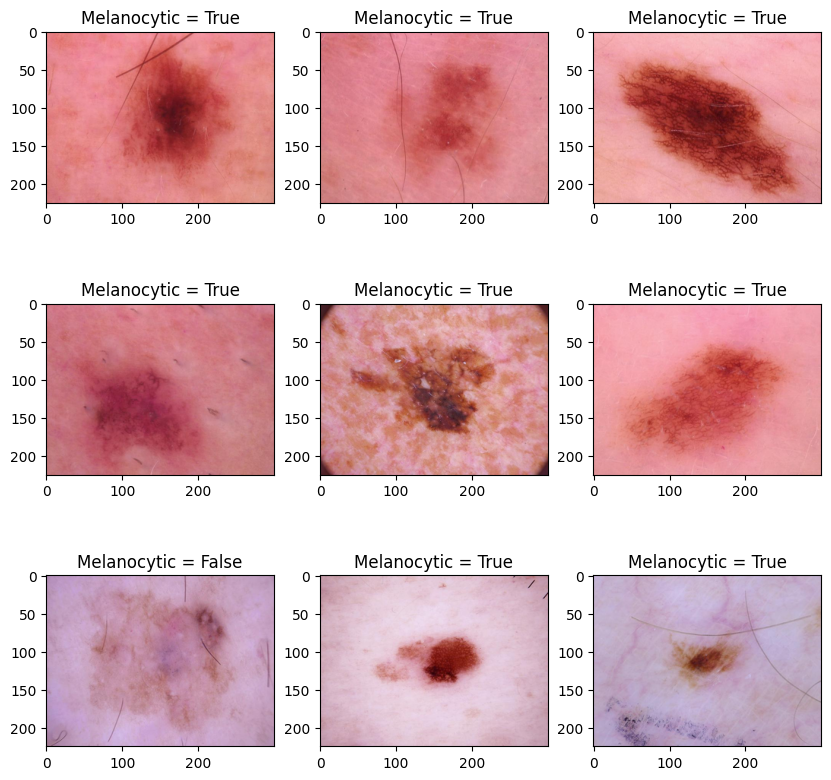

In [5]:
plt.figure(figsize=(10, 10))

for index, digit in zip(range(0, 9), dataset_X[:10]):
    plt.subplot(3, 3, index + 1)
    plt.imshow(digit)
    if dataset_Y[index] == True:
      plt.title("Melanocytic = True")
    else:
      plt.title("Melanocytic = False")
plt.show()

## 3 - Validate that we have the same proportion of True-False values from our loaded images as in the CSV data


In [6]:
print("**********Melanocytic: values distribution from data loaded from CSV files**************\n")
print(df['melanocytic'].value_counts() , "\n")

print("**********Melanocytic: values distribution from builded dataset **************\n")
unique_originals, counts_originals = np.unique(dataset_Y, return_counts=True)
print(str(unique_originals[1]) + " ----> " + str(counts_originals[1]))
print(str(unique_originals[0]) + " ----> " + str(counts_originals[0]))

**********Melanocytic: values distribution from data loaded from CSV files**************

melanocytic
True     9042
False    2678
Name: count, dtype: int64 

**********Melanocytic: values distribution from builded dataset **************

True ----> 9042
False ----> 2678


## 4 - Data Preparation and splitting the dataset


## - We split the data in a proportion of 60% training, 20% validation and 20% test

In [7]:
# Step 1: Split into train (60%) and remaining (40%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset_X, dataset_Y, train_size=0.6)


# Step 2: Split remaining data into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (7032, 225, 300, 3)
Dimensions of training labels:  (7032,)
Dimensions of validation data:  (2344, 225, 300, 3)
Dimensions of validation labels:  (2344,)
Dimensions of test data:  (2344, 225, 300, 3)
Dimensions of test data:  (2344,)


## **** - Visualize the first 3 images across splits to see them changing every time we run the notebook and make sure splits are working


********** Examples from Train Split***********


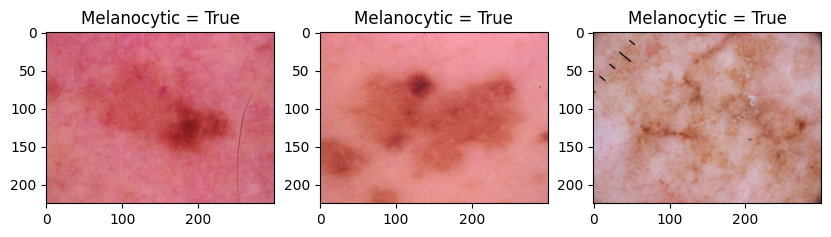

********** Examples from Validation Split***********


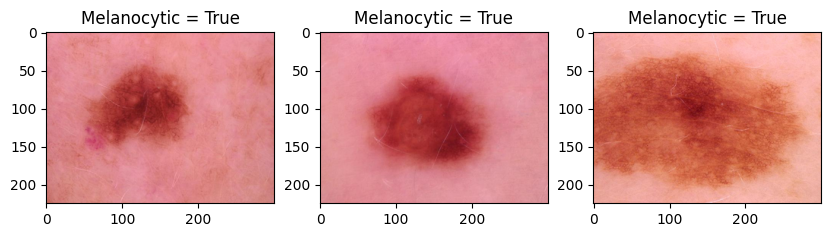

********** Examples from Test Split***********


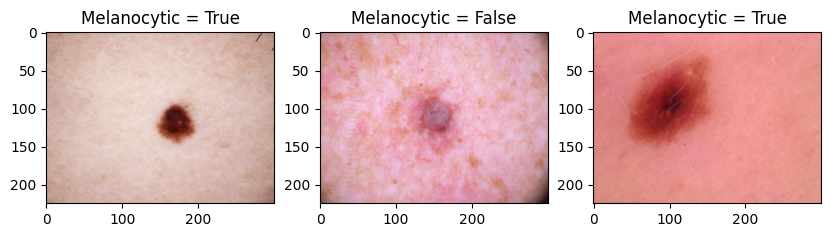

In [8]:
def plotImages(amount, data, labels):
    plt.figure(figsize=(10, 10))
    for index, digit in zip(range(0, amount), data):
        plt.subplot(amount, amount, index + 1)
        plt.imshow(digit)
        plt.title("Melanocytic = " + str(labels[index]))
    plt.show()

print("********** Examples from Train Split***********")
plotImages(3, X_train[:10], y_train)
print("********** Examples from Validation Split***********")
plotImages(3, X_val[:10], y_val)
print("********** Examples from Test Split***********")
plotImages(3, X_test[:10], y_test)

### - Now we do data normalization and pixel value transformation across our splitting data 

In [9]:
d1, d2, d3, d4 = X_train.shape

X_train_prep = X_train.reshape((d1, d2*d3*d4))
X_train_prep = X_train_prep.astype('float32') / 255

d1, d2, d3, d4 = X_val.shape

X_val_prep = X_val.reshape((d1, d2*d3*d4))
X_val_prep = X_val_prep.astype('float32') / 255

d1, d2, d3, d4 = X_test.shape

X_test_prep = X_test.reshape((d1, d2*d3*d4))
X_test_prep = X_test_prep.astype('float32') / 255



print("Example of pixel transformation for an image", X_train_prep[0])

Example of pixel transformation for an image [0.7647059  0.34509805 0.42352942 ... 0.7921569  0.43529412 0.50980395]


## 5-  Define the Neural Network Architecture and build model with Keras Tuner

In [10]:
def model_builder(hp):

    model = keras.Sequential()
    
    model.add(layers.Dense(
        units=hp.Int('units1', min_value=200, max_value=500, step=100),
        activation='relu'
    ))

    model.add(BatchNormalization())

    model.add(layers.Dense(
        units=hp.Int('units2', min_value=50, max_value=100, step=10),
        activation='relu'
    ))

    model.add(BatchNormalization())

    model.add(layers.Dense(
        units=hp.Int('units3', min_value=10, max_value=50, step=5),
        activation='relu'
    ))

    model.add(BatchNormalization())

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))


    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-2, max_value=0.1)
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision']
    )
    
    return model

## Instantiate Tuner object to do _hypertuning_

In [11]:
# Instantiate the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=8,
    directory='test_dir',
    project_name='hp_tuning'
)

Reloading Tuner from test_dir\hp_tuning\tuner0.json


## Execute the tuner

In [12]:
tuner.search(
    X_train_prep,
    y_train,
    epochs = 8,
    validation_data=(X_val_prep, y_val)
)

### Visualize obtained hyperparameters

In [13]:
best_hp = tuner.get_best_hyperparameters()[0]

# Extract the best units and learning rate
best_units1 = best_hp.get('units1')
best_units2 = best_hp.get('units2')
best_units3 = best_hp.get('units3')
best_learning_rate = best_hp.get('learning_rate')

print(f" ******** Best units in first hidden layer: {best_units1}")
print(f" ******** Best units in second hidden layer: {best_units2}")
print(f" ******** Best units in third hidden layer: {best_units3}")
print(f"Best learning rate: {best_learning_rate}")


 ******** Best units in first hidden layer: 200
 ******** Best units in second hidden layer: 80
 ******** Best units in third hidden layer: 35
Best learning rate: 0.04039588485608032


### Summarize the best model obtained

In [14]:
model = tuner.hypermodel.build(best_hp)

model.build(input_shape=(None, X_train_prep.shape[1])) 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               40500200  
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 batch_normalization_1 (Batc  (None, 80)               320       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 35)                2835      
                                                                 
 batch_normalization_2 (Batc  (None, 35)               1

## 6 - Training phase

In [15]:
history = model.fit(X_train_prep,
                      y_train,
                      epochs=10,
                      validation_data=(X_val_prep, y_val))

Epoch 1/10
220/220 [==============================] - 24s 102ms/step - loss: 0.4489 - accuracy: 0.7814 - precision: 0.8130 - val_loss: 0.6271 - val_accuracy: 0.7526 - val_precision: 0.8572
Epoch 2/10
220/220 [==============================] - 22s 98ms/step - loss: 0.4199 - accuracy: 0.8057 - precision: 0.8329 - val_loss: 0.5634 - val_accuracy: 0.7095 - val_precision: 0.9176
Epoch 3/10
220/220 [==============================] - 22s 101ms/step - loss: 0.3983 - accuracy: 0.8198 - precision: 0.8480 - val_loss: 0.4170 - val_accuracy: 0.8025 - val_precision: 0.8605
Epoch 4/10
220/220 [==============================] - 23s 106ms/step - loss: 0.3938 - accuracy: 0.8194 - precision: 0.8524 - val_loss: 0.4571 - val_accuracy: 0.7794 - val_precision: 0.7789
Epoch 5/10
220/220 [==============================] - 23s 104ms/step - loss: 0.3815 - accuracy: 0.8259 - precision: 0.8589 - val_loss: 1.2624 - val_accuracy: 0.5789 - val_precision: 0.9582
Epoch 6/10
220/220 [==============================] - 23

## 7 - Visualize metrics from the training phase

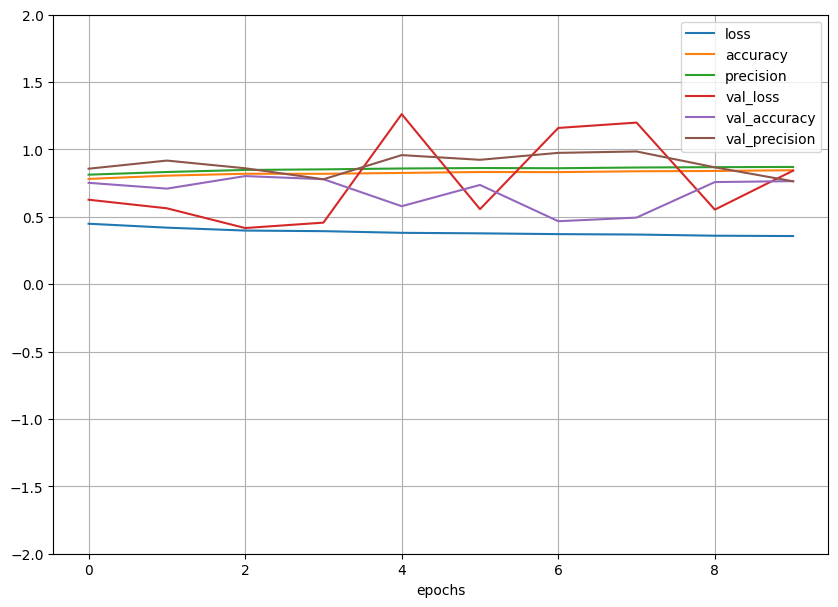

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.xlabel("epochs")
plt.show()

### • Check the accuracy, precision and loss

In [17]:
test_loss, test_acc, test_prec = model.evaluate(X_test_prep, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_loss)

74/74 [==============================] - 2s 29ms/step - loss: 0.7263 - accuracy: 0.7846 - precision: 0.7849
Test accuracy:  0.7845563292503357
Test Precision: 0.7848536968231201
Test Loss: 0.7263035178184509


## 8 - Final Results

74/74 [==============================] - 2s 25ms/step


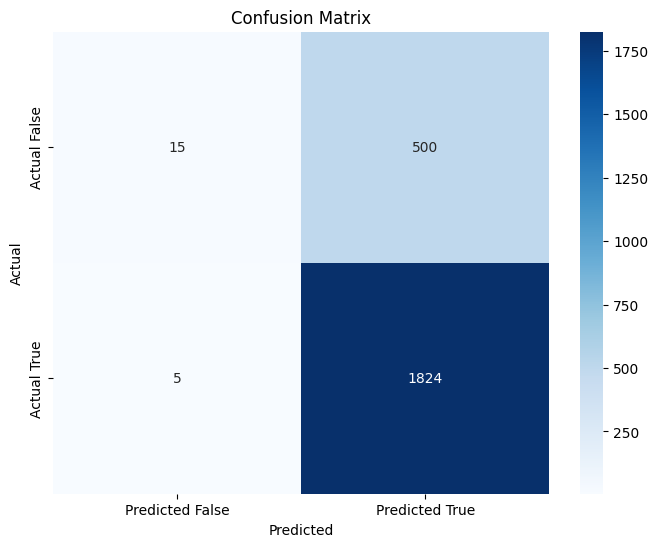

In [18]:
predictions = model.predict(X_test_prep)

y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ** Conclusions Part 1 **

### This model is good at predicting the images with the Melanocytic = True, but is not very good at predicting the ones with that category on False

# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569 - Parte 2

### • We use the already loaded data on Part 1 

In [19]:
df.info()
print("Size of images for the dataset: ", dataset_X.shape)
print("Size of labels of the dataset: ", dataset_Y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB
Size of images for the dataset:  (

In [20]:
print("**********Melanocytic: values distribution from data loaded from CSV files**************\n")
print(df['melanocytic'].value_counts() , "\n")

print("**********Melanocytic: values distribution from builded dataset **************\n")
unique_originals, counts_originals = np.unique(dataset_Y, return_counts=True)
print(str(unique_originals[1]) + " ----> " + str(counts_originals[1]))
print(str(unique_originals[0]) + " ----> " + str(counts_originals[0]))

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)

**********Melanocytic: values distribution from data loaded from CSV files**************

melanocytic
True     9042
False    2678
Name: count, dtype: int64 

**********Melanocytic: values distribution from builded dataset **************

True ----> 9042
False ----> 2678
Dimensions of training data:  (7032, 225, 300, 3)
Dimensions of training labels:  (7032,)
Dimensions of validation data:  (2344, 225, 300, 3)
Dimensions of validation labels:  (2344,)
Dimensions of test data:  (2344, 225, 300, 3)
Dimensions of test data:  (2344,)


### • It is important to notice that we are using the data splitted but without the reshaping and normalization because for CNN we will Conv2D, so we need to rescale the pixels but keep the matrix shape

In [21]:

X_train_normalized = X_train.astype('float32') / 255

X_val_normalized = X_val.astype('float32') / 255

X_test_normalized = X_test.astype('float32') / 255


### - Login to WANDB and set it up

In [22]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Network error (SSLError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [23]:
wandb.init(
    # set the wandb project where this run will be logged
    project="melanocytic-CNN-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "ISIC",
    "epochs": 15,
    }
)

### • Define the CNN architecture

In [24]:
input_shape=X_train_normalized[0].shape
filters = 32
kernel_size = (3,3)
pool_size = (2,2)

optimizer = 'adam'
loss = 'binary_crossentropy'
metrics=['accuracy', 'Precision']
activation = 'relu'
activation_function_output = 'sigmoid'

number_of_cnn_layers = 3
number_of_ff_layers = 3
number_of_units_output = 1

cnn_model = Sequential()

cnn_model.add(Conv2D(filters, kernel_size, input_shape = input_shape,
                     activation = activation))

cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = pool_size))

for i in range(number_of_cnn_layers - 1):
    cnn_model.add(Conv2D(filters, kernel_size, activation = activation))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size = pool_size))

cnn_model.add(Flatten())

#Feedforward network
for i in range(number_of_ff_layers):
    cnn_model.add(Dense(units = 64, activation = activation))
    cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(units = number_of_units_output,
                    activation = activation_function_output))

cnn_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [25]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 298, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 223, 298, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 147, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 109, 147, 32)     128       
 hNormalization)                                                 
                                                      

### • Training phase

In [26]:
batch_size = 32
epochs = 10

# Define a W&B Callback
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

history = cnn_model.fit(X_train_normalized, y_train,
              batch_size = batch_size, epochs = epochs, validation_data=(X_val_normalized, y_val), callbacks=[WandbCallback()])

Epoch 1/10
220/220 [==============================] - 145s 649ms/step - loss: 0.8055 - accuracy: 0.7538 - precision: 0.8201 - val_loss: 1.4059 - val_accuracy: 0.2496 - val_precision: 0.8148
Epoch 2/10
220/220 [==============================] - 155s 705ms/step - loss: 0.5596 - accuracy: 0.7763 - precision: 0.8076 - val_loss: 0.5688 - val_accuracy: 0.7705 - val_precision: 0.8248
Epoch 3/10
220/220 [==============================] - 138s 627ms/step - loss: 0.4372 - accuracy: 0.7935 - precision: 0.8058 - val_loss: 0.4029 - val_accuracy: 0.7777 - val_precision: 0.7766
Epoch 4/10
220/220 [==============================] - 138s 628ms/step - loss: 0.4092 - accuracy: 0.8043 - precision: 0.8140 - val_loss: 0.3876 - val_accuracy: 0.8003 - val_precision: 0.8082
Epoch 5/10
220/220 [==============================] - 137s 622ms/step - loss: 0.3898 - accuracy: 0.8170 - precision: 0.8278 - val_loss: 0.4122 - val_accuracy: 0.7867 - val_precision: 0.7871
Epoch 6/10
220/220 [==============================

### • Visualize metrics from the training phase

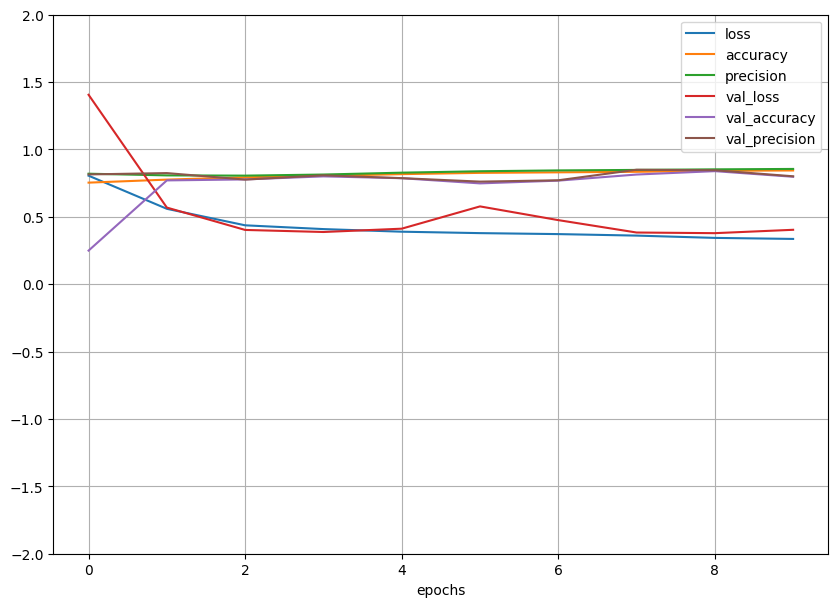

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(-2, 2)
plt.xlabel("epochs")
plt.show()

In [28]:
test_loss, test_acc, test_prec = cnn_model.evaluate(X_test_normalized, y_test)
print('Test Loss:', test_loss)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)

74/74 [==============================] - 10s 136ms/step - loss: 0.3519 - accuracy: 0.8268 - precision: 0.8280
Test Loss: 0.3519357740879059
Test accuracy:  0.8267918229103088
Test Precision: 0.8280313611030579


74/74 [==============================] - 9s 125ms/step


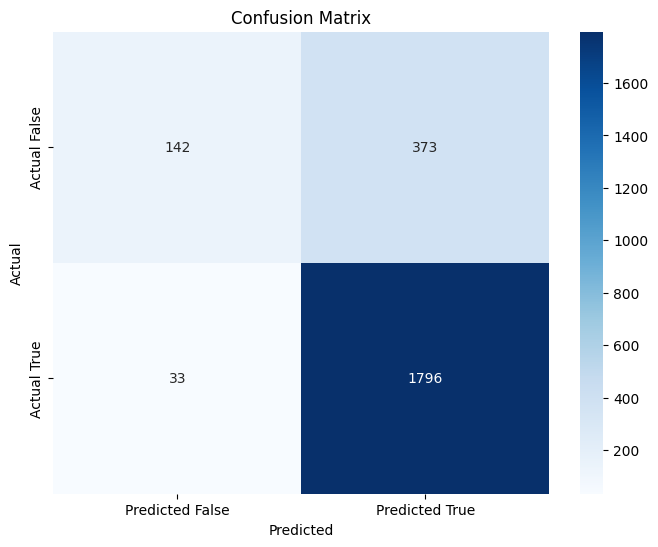

In [29]:
predictions = cnn_model.predict(X_test_normalized)

y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted False', 'Predicted True'], yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Conclusions